# Prepare libraries

In [50]:
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import cv2
import logging
import matplotlib.pyplot as plt
logging.basicConfig(format='%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# BoVW

In [71]:
class BoVW:
    def __init__(self, extractor, train_images=None, class_num=2, vocabulary_size=5):
        
        self.extractor = extractor
        self.class_num = class_num
        self.vocabulary_size = vocabulary_size
        self.train_images = train_images
        self.cluster_model = KMeans(n_clusters=class_num)
        self.scaler = StandardScaler()
        self.train_histograms = None
        self.predictor = None
        
        if self.train_images is not None:
            print("Training BoVW starts ...")
            print("Extracting descriptors ...")
            train_desc = self._get_images_descriptors(self.train_images)
            print("Grouping descriptors ...")
            all_descriptors_list = self._get_descriptors_list(train_desc)
            print("Descriptors extracted from tarin images")
            print("Training cluster model ...")
            self._train_cluster_model(all_descriptors_list,vocabulary_size)
            print("Cluster model trained")
            train_histograms = self._get_histograms(train_desc)
            print("Histograms computed")
            self.scaler.fit(train_histograms)  
            self.train_histograms = self.scaler.transform(train_histograms)
            print("Histograms normalized")
            
            
    
    def _get_image_descriptors(self,image):
        keypoints, descriptors = self.extractor.detectAndCompute(image, None)
        return keypoints, descriptors
    
    
    def _get_images_descriptors(self,images):
        descriptors = []
        
        for image in tqdm(images):
            _, img_features = self._get_image_descriptors(image)
            if img_features is not None:
                descriptors.append(img_features)
        return np.array(descriptors)
        
    def _get_descriptors_list(self, descriptors):
        stacked_descriptors = np.array(descriptors[0])
        for descriptor in tqdm(descriptors[1:]):
            if descriptor is not None:
                stacked_descriptors = np.vstack((stacked_descriptors, descriptor))
        
        return stacked_descriptors
        
    
    def _train_cluster_model(self, descriptors, cluster_num=2):
        self.cluster_model = KMeans(n_clusters=cluster_num).fit(descriptors)
    
    
    def _get_histograms(self, descriptors):
        histograms = np.zeros((descriptors.shape[0], self.vocabulary_size))
        
        for i in tqdm(range(descriptors.shape[0])):
            for j in range(len(descriptors[i])):
                feature = descriptors[i][j]
                feature = feature.reshape(1, 128)
                idx = self.cluster_model.predict(feature)
                histograms[i][idx] += 1
        return histograms

                
    def plot_histograms(self, histograms):
        x_scalar = np.arange(self.class_num)
        y_scalar = np.array([abs(np.sum(features[:,h], dtype=np.int32)) for h in range(self.class_num)])

        plt.bar(x_scalar, y_scalar)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Complete Vocabulary Generated")
        plt.xticks(x_scalar + 0.4, x_scalar)
        plt.show()
        
    def plot_nearest_neighbours(self, neighbour_ids, distances=None):
        count = len(neighbour_ids)
        plt.figure(figsize=(20,10))
        for i in range(len(neighbour_ids)):
            idx = neighbour_ids[i]
            subplot = plt.subplot(1, count, i+1)
            if distances is not None:
                subplot.set_title("Distance: {:10.4f}".format(distances[i]))
      
            img = self.train_images[idx]
            cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
            subplot.imshow(img, cmap=cmap)
        plt.show()
        
        
    def get_neares_neighbours(self, image, n_neighbours):
        
        _, descriptor = self._get_image_descriptors(image)
        descriptors = np.array([descriptor])
        
        histograms = self._get_histograms(descriptors)
        histogram = self.scaler.transform(histograms)[0]
        
        knn = NearestNeighbors(n_neighbors=n_neighbours)
        knn.fit(self.train_histograms)
        return knn.kneighbors([histogram])
        

# Test on MNIST

In [60]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

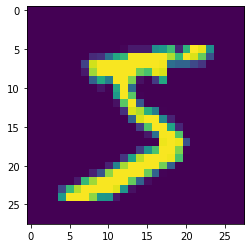

In [61]:
plt.imshow(x_train[0])
plt.show()

In [72]:
bovw = BoVW(extractor=cv2.xfeatures2d.SIFT_create(), train_images=x_train[:10000], class_num=10)

  2%|▏         | 154/10000 [00:00<00:06, 1534.36it/s]

Training BoVW starts ...
Extracting descriptors ...


  8%|▊         | 829/9768 [00:00<00:01, 8286.83it/s]

Grouping descriptors ...


100%|██████████| 9768/9768 [00:19<00:00, 497.26it/s] 


Descriptors extracted from tarin images
Training cluster model ...


  0%|          | 36/9769 [00:00<00:27, 356.71it/s]

Cluster model trained


100%|██████████| 9769/9769 [00:19<00:00, 498.67it/s]

Histograms computed
Histograms normalized


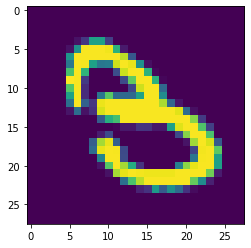

100%|██████████| 1/1 [00:00<00:00, 180.05it/s]


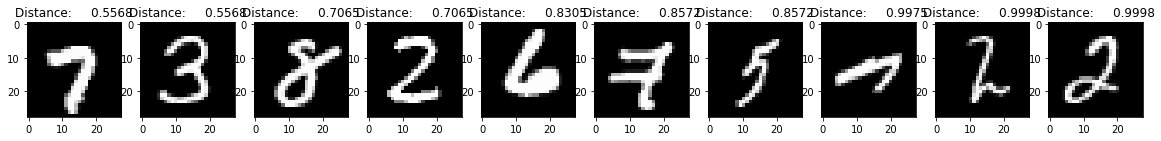

In [100]:
test_img = x_test[18]
plt.imshow(test_img)
plt.show()
dists, ids = bovw.get_neares_neighbours(test_img, n_neighbours=10)
bovw.plot_nearest_neighbours(ids[0], dists[0])

# Test on CIFAR-10

In [75]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


170500096/170498071 [==============================] - 410s 2us/step


In [ ]:
train_X = []
for i in range(10000):
    img = cv2.colorChange()

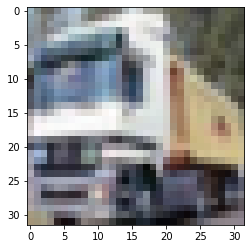

In [77]:
plt.imshow(train_images[1])
plt.show()

In [78]:
bovw2 = BoVW(extractor=cv2.xfeatures2d.SIFT_create(), train_images=train_images[:10000], class_num=10)

  1%|          | 81/10000 [00:00<00:12, 805.76it/s]

Training BoVW starts ...
Extracting descriptors ...


  6%|▌         | 574/9974 [00:00<00:01, 5712.44it/s]

Grouping descriptors ...


100%|██████████| 9974/9974 [00:34<00:00, 286.84it/s] 


Descriptors extracted from tarin images
Training cluster model ...


  0%|          | 28/9975 [00:00<00:35, 277.52it/s]

Cluster model trained


100%|██████████| 9975/9975 [00:32<00:00, 309.72it/s]

Histograms computed
Histograms normalized


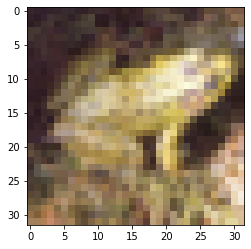

100%|██████████| 1/1 [00:00<00:00, 331.36it/s]


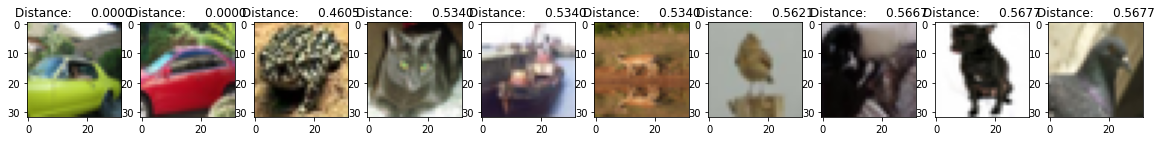

In [98]:
test_img = test_images[19]
plt.imshow(test_img)
plt.show()
dists, ids = bovw2.get_neares_neighbours(test_img, n_neighbours=10)
bovw2.plot_nearest_neighbours(ids[0], dists[0])